In [1]:
## 1. 라이브러리 불러오기

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random
from datetime import datetime
import re
import pickle

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [2]:
## 2. 데이터 로드 함수 정의

def load_yelp_json(file_path, n_samples=None):
    """
    Yelp 데이터셋의 JSON 파일을 로드하는 함수
    
    Args:
        file_path (str): JSON 파일 경로
        n_samples (int, optional): 로드할 샘플 수 (None이면 전체 로드)
    
    Returns:
        pd.DataFrame: 로드된 데이터
    """
    print(f"{file_path} 로딩 중...")
    data = []
    
    # 파일 라인 수 계산 (진행률 표시용)
    if n_samples is None:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, _ in enumerate(f):
                pass
        total_lines = i + 1
        print(f"총 {total_lines:,}개의 데이터가 있습니다.")
    else:
        total_lines = n_samples
        print(f"{n_samples:,}개의 샘플을 로드합니다.")
    
    # 데이터 로드
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f), total=total_lines):
            if n_samples is not None and i >= n_samples:
                break
            data.append(json.loads(line))
    
    # DataFrame으로 변환
    df = pd.DataFrame(data)
    print(f"로드 완료: {len(df):,}개 데이터, {df.shape[1]}개 컬럼")
    return df


In [ ]:
## 2. 데이터 로드 함수 정의 

import time

## 개선된 데이터 로딩 및 샘플링 전략

def load_yelp_json_smart(file_path, n_samples=None, random_sampling=False):
    """
    Yelp 데이터셋의 JSON 파일을 로드하는 함수 (개선된 버전)
    
    Args:
        file_path (str): JSON 파일 경로
        n_samples (int, optional): 로드할 샘플 수 (None이면 전체 로드)
        random_sampling (bool): 랜덤 샘플링 여부
    
    Returns:
        pd.DataFrame: 로드된 데이터
    """
    print(f"\n{file_path} 로딩 중...")
    data = []
    
    # 파일의 총 라인 수 계산
    with open(file_path, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)
        print(f"총 {total_lines:,}개의 데이터가 있습니다.")
    
    # 샘플링 전략 결정
    if n_samples is None:
        lines_to_read = total_lines
        sampling_rate = 1.0
    else:
        lines_to_read = min(n_samples, total_lines)
        sampling_rate = lines_to_read / total_lines
    
    print(f"{lines_to_read:,}개의 샘플을 로드합니다. (샘플링 비율: {sampling_rate:.1%})")
    
    # 데이터 로드
    read_count = 0
    if random_sampling:
        # 랜덤 샘플링
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, total=total_lines):
                if np.random.random() < sampling_rate:
                    data.append(json.loads(line))
                    read_count += 1
                    if read_count >= lines_to_read:
                        break
    else:
        # 순차적 샘플링 (첫 N개 행)
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in tqdm(enumerate(f), total=lines_to_read):
                if i >= lines_to_read:
                    break
                data.append(json.loads(line))
    
    df = pd.DataFrame(data)
    print(f"로드 완료: {len(df):,}개 데이터, {df.shape[1]}개 컬럼")
    return df

# 효율적인 데이터 로딩 전략
def load_data_with_fallback():
    '''
    데이터를 단계적으로 로드하는 함수
    '''
    # 1차 시도: 작은 샘플
    try:
        print("=== 1차 시도: 작은 샘플 로드 ===")
        business_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"), 10000)
        
        # 데이터 분포 확인
        restaurant_categories = ['Restaurants', 'Food', 'Bars']
        cat_mask = business_df['categories'].apply(
            lambda x: any(cat.strip() in restaurant_categories for cat in x.split(',')) if isinstance(x, str) else False
        )
        restaurant_ratio = cat_mask.mean()
        print(f"레스토랑 비율: {restaurant_ratio:.1%}")
        
        # 필요한 데이터 크기 추정
        target_restaurant_count = 5000
        estimated_total_needed = int(target_restaurant_count / restaurant_ratio)
        
        print(f"목표 레스토랑 수: {target_restaurant_count:,}")
        print(f"필요한 총 비즈니스 수: {estimated_total_needed:,}")
        
        # 2차 시도: 적절한 크기로 로드
        print(f"\n=== 2차 시도: {estimated_total_needed:,}개 데이터 로드 ===")
        actual_load_size = min(estimated_total_needed * 2, 100000)  # 여유있게 2배
        
        business_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"), actual_load_size)
        user_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_user.json"), actual_load_size)
        review_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_review.json"), actual_load_size * 5)
        tip_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_tip.json"), actual_load_size)
        checkin_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_checkin.json"), actual_load_size)
        
        return business_df, user_df, review_df, tip_df, checkin_df
        
    except Exception as e:
        print(f"데이터 로딩 실패: {e}")
        return None, None, None, None, None

# 더 안전한 필터링 함수
def safe_filter_pipeline(business_df, review_df, user_df, tip_df, checkin_df):
    """
    단계별로 필터링하면서 데이터 유실 방지
    """
    print("\n=== 안전한 필터링 파이프라인 시작 ===")
    
    # 1. 먼저 기본적인 데이터 품질 확인
    print(f"초기 데이터 크기:")
    print(f"- 비즈니스: {len(business_df):,}")
    print(f"- 리뷰: {len(review_df):,}")
    print(f"- 사용자: {len(user_df):,}")
    
    # 2. 가장 관대한 조건부터 시작
    restaurant_categories = ['Restaurants', 'Food', 'Bars', 'Nightlife', 'Cafes', 'Coffee & Tea', 'Fast Food']
    
    # 카테고리 필터링
    cat_mask = business_df['categories'].apply(
        lambda x: any(cat.strip() in restaurant_categories for cat in x.split(',')) if isinstance(x, str) else False
    )
    filtered_business = business_df[cat_mask]
    print(f"\n카테고리 필터링 후 비즈니스: {len(filtered_business):,}")
    
    # 데이터가 너무 적으면 조건 완화
    if len(filtered_business) < 1000:
        print("데이터가 부족하여 모든 비즈니스 사용")
        filtered_business = business_df
    
    # 3. 리뷰 수 기준 필터링 (유연하게)
    review_threshold = 5 if len(filtered_business) > 5000 else 1
    final_business = filtered_business[filtered_business['review_count'] >= review_threshold]
    print(f"\n리뷰 수 {review_threshold}개 이상 비즈니스: {len(final_business):,}")
    
    # 4. 상호작용 데이터 확보
    business_ids = set(final_business['business_id'])
    filtered_reviews = review_df[review_df['business_id'].isin(business_ids)]
    print(f"해당 비즈니스의 리뷰: {len(filtered_reviews):,}")
    
    # 5. 사용자 데이터 필터링
    user_ids = set(filtered_reviews['user_id'])
    filtered_users = user_df[user_df['user_id'].isin(user_ids)]
    print(f"리뷰 작성 사용자: {len(filtered_users):,}")
    
    # 6. 충분한 데이터가 있는지 확인
    if len(filtered_reviews) < 1000:
        print("\n경고: 상호작용 데이터가 부족합니다. 다시 로드하는 것을 권장합니다.")
    
    return final_business, filtered_reviews, filtered_users

# 실행 예시
if __name__ == "__main__":
    # 데이터 로드
    business_df, user_df, review_df, tip_df, checkin_df = load_data_with_fallback()
    
    if business_df is not None:
        # 안전한 필터링 실행
        sampled_business, sampled_review, sampled_user = safe_filter_pipeline(
            business_df, review_df, user_df, tip_df, checkin_df
        )
        
        print("\n=== 최종 데이터 요약 ===")
        print(f"비즈니스: {len(sampled_business):,}")
        print(f"리뷰: {len(sampled_review):,}")
        print(f"사용자: {len(sampled_user):,}")


## 3. 데이터 로드

# 데이터 파일 경로 설정
DATA_DIR = "./yelp_dataset"  # 원본 데이터 경로
PROCESSED_DIR = "./data/processed"  # 처리된 데이터 저장 경로

# 디렉토리 생성
os.makedirs(PROCESSED_DIR, exist_ok=True)

# 샘플 수 설정 - 이전보다 많이!
N_BUSINESS = 50000  # 비즈니스 수 (10000 -> 50000)
N_USER = 100000    # 사용자 수 (20000 -> 100000)
N_REVIEW = 500000  # 리뷰 수 (100000 -> 500000)
N_TIP = 50000      # 팁 수 (20000 -> 50000)
N_CHECKIN = 50000  # 체크인 수 (10000 -> 50000)

# 데이터 로드 - load_yelp_json 대신 load_yelp_json_smart 사용
business_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"), N_BUSINESS)
user_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_user.json"), N_USER)
review_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_review.json"), N_REVIEW)
tip_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_tip.json"), N_TIP)
checkin_df = load_yelp_json_smart(os.path.join(DATA_DIR, "yelp_academic_dataset_checkin.json"), N_CHECKIN)

=== 1차 시도: 작은 샘플 로드 ===

./yelp_dataset\yelp_academic_dataset_business.json 로딩 중...
총 150,346개의 데이터가 있습니다.
10,000개의 샘플을 로드합니다. (샘플링 비율: 6.7%)


100%|██████████| 10000/10000 [00:00<00:00, 23427.22it/s]


로드 완료: 10,000개 데이터, 14개 컬럼
레스토랑 비율: 44.2%
목표 레스토랑 수: 5,000
필요한 총 비즈니스 수: 11,301

=== 2차 시도: 11,301개 데이터 로드 ===

./yelp_dataset\yelp_academic_dataset_business.json 로딩 중...
총 150,346개의 데이터가 있습니다.
22,602개의 샘플을 로드합니다. (샘플링 비율: 15.0%)


100%|██████████| 22602/22602 [00:01<00:00, 16873.00it/s]


로드 완료: 22,602개 데이터, 14개 컬럼

./yelp_dataset\yelp_academic_dataset_user.json 로딩 중...
총 1,987,897개의 데이터가 있습니다.
22,602개의 샘플을 로드합니다. (샘플링 비율: 1.1%)


100%|██████████| 22602/22602 [00:00<00:00, 23620.98it/s]


로드 완료: 22,602개 데이터, 22개 컬럼

./yelp_dataset\yelp_academic_dataset_review.json 로딩 중...
총 6,990,280개의 데이터가 있습니다.
113,010개의 샘플을 로드합니다. (샘플링 비율: 1.6%)


100%|██████████| 113010/113010 [00:01<00:00, 73098.12it/s]


로드 완료: 113,010개 데이터, 9개 컬럼

./yelp_dataset\yelp_academic_dataset_tip.json 로딩 중...
총 908,915개의 데이터가 있습니다.
22,602개의 샘플을 로드합니다. (샘플링 비율: 2.5%)


100%|██████████| 22602/22602 [00:00<00:00, 206959.49it/s]

로드 완료: 22,602개 데이터, 5개 컬럼

./yelp_dataset\yelp_academic_dataset_checkin.json 로딩 중...


총 131,930개의 데이터가 있습니다.
22,602개의 샘플을 로드합니다. (샘플링 비율: 17.1%)


100%|██████████| 22602/22602 [00:00<00:00, 91832.10it/s]


로드 완료: 22,602개 데이터, 2개 컬럼

=== 안전한 필터링 파이프라인 시작 ===
초기 데이터 크기:
- 비즈니스: 22,602
- 리뷰: 113,010
- 사용자: 22,602

카테고리 필터링 후 비즈니스: 10,191

리뷰 수 5개 이상 비즈니스: 10,191
해당 비즈니스의 리뷰: 90,807
리뷰 작성 사용자: 9,524

=== 최종 데이터 요약 ===
비즈니스: 10,191
리뷰: 90,807
사용자: 9,524

./yelp_dataset\yelp_academic_dataset_business.json 로딩 중...
총 150,346개의 데이터가 있습니다.
50,000개의 샘플을 로드합니다. (샘플링 비율: 33.3%)


100%|██████████| 50000/50000 [00:00<00:00, 82511.11it/s] 


로드 완료: 50,000개 데이터, 14개 컬럼

./yelp_dataset\yelp_academic_dataset_user.json 로딩 중...
총 1,987,897개의 데이터가 있습니다.
100,000개의 샘플을 로드합니다. (샘플링 비율: 5.0%)


100%|██████████| 100000/100000 [00:01<00:00, 70770.56it/s]


로드 완료: 100,000개 데이터, 22개 컬럼

./yelp_dataset\yelp_academic_dataset_review.json 로딩 중...
총 6,990,280개의 데이터가 있습니다.
500,000개의 샘플을 로드합니다. (샘플링 비율: 7.2%)


100%|██████████| 500000/500000 [00:02<00:00, 188518.72it/s]


로드 완료: 500,000개 데이터, 9개 컬럼

./yelp_dataset\yelp_academic_dataset_tip.json 로딩 중...
총 908,915개의 데이터가 있습니다.
50,000개의 샘플을 로드합니다. (샘플링 비율: 5.5%)


100%|██████████| 50000/50000 [00:00<00:00, 367957.55it/s]

로드 완료: 50,000개 데이터, 5개 컬럼



./yelp_dataset\yelp_academic_dataset_checkin.json 로딩 중...
총 131,930개의 데이터가 있습니다.
50,000개의 샘플을 로드합니다. (샘플링 비율: 37.9%)


100%|██████████| 50000/50000 [00:00<00:00, 146427.38it/s]

로드 완료: 50,000개 데이터, 2개 컬럼


In [3]:
import os
import json
import time
from typing import Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import gc  # 가비지 컬렉션 모듈

# ────────────────────────────────────────────────────────────────────────────────
# 1. 메모리 효율적인 JSON 로더
# ────────────────────────────────────────────────────────────────────────────────

def load_yelp_json_smart(
    file_path: str,
    n_samples: Optional[int] = None,
    random_sampling: bool = False,
    chunk_size: int = 50000  # 청크 크기 추가
) -> pd.DataFrame:
    """Memory-efficient loader for large Yelp JSON files.

    Args:
        file_path: full path to the *.json* file.
        n_samples: number of lines to read. ``None`` → read *all* lines.
        random_sampling: if ``True`` use probabilistic sampling, otherwise
            read first *n_samples* sequentially.
        chunk_size: number of lines to process in each chunk.

    Returns
    -------
    pd.DataFrame
        DataFrame built from loaded JSON objects.
    """

    print(f"\n{file_path} 로딩 중…")
    
    # 1) count lines -----------------------------------------------------------
    with open(file_path, "r", encoding="utf-8") as f:
        total_lines = sum(1 for _ in f)
    print(f"총 {total_lines:,}개의 데이터가 있습니다.")

    # 2) decide how many lines to read ----------------------------------------
    if n_samples is None:
        lines_to_read = total_lines
        sampling_rate = 1.0
    else:
        lines_to_read = min(n_samples, total_lines)
        sampling_rate = lines_to_read / total_lines
    print(f"{lines_to_read:,}개의 샘플을 로드합니다. (샘플링 비율: {sampling_rate:.1%})")

    # 3) read in chunks --------------------------------------------------------
    all_chunks = []
    read_cnt = 0
    
    # 청크 단위로 처리하기 위한 설정
    total_chunks = (lines_to_read + chunk_size - 1) // chunk_size
    
    with open(file_path, "r", encoding="utf-8") as f:
        for chunk_idx in range(total_chunks):
            chunk_data = []
            chunk_start = time.time()
            
            print(f"청크 {chunk_idx+1}/{total_chunks} 처리 중...")
            
            if random_sampling:
                # 랜덤 샘플링 경우
                lines_in_chunk = 0
                while lines_in_chunk < chunk_size and read_cnt < lines_to_read:
                    line = f.readline()
                    if not line:  # 파일 끝에 도달
                        break
                    
                    if np.random.random() < sampling_rate:
                        try:
                            chunk_data.append(json.loads(line))
                            read_cnt += 1
                            lines_in_chunk += 1
                        except json.JSONDecodeError:
                            print(f"경고: JSON 파싱 오류 발생, 라인 스킵")
                            continue
            else:
                # 순차 로딩 경우
                for _ in range(chunk_size):
                    if read_cnt >= lines_to_read:
                        break
                    
                    line = f.readline()
                    if not line:  # 파일 끝에 도달
                        break
                    
                    try:
                        chunk_data.append(json.loads(line))
                        read_cnt += 1
                    except json.JSONDecodeError:
                        print(f"경고: JSON 파싱 오류 발생, 라인 스킵")
                        continue
            
            # 현재 청크를 DataFrame으로 변환
            if chunk_data:
                chunk_df = pd.DataFrame(chunk_data)
                all_chunks.append(chunk_df)
                
                # 진행 상황 및 메모리 사용량 출력
                chunk_end = time.time()
                print(f"  ↪ {len(chunk_data):,}개 레코드 처리 완료 ({chunk_end-chunk_start:.2f}초)")
                
                # 중간 메모리 정리
                del chunk_data
                gc.collect()
            
            if read_cnt >= lines_to_read:
                break
    
    # 모든 청크 결합
    if all_chunks:
        print("모든 청크를 결합하는 중...")
        df = pd.concat(all_chunks, ignore_index=True)
        print(f"로드 완료: {len(df):,}개 데이터, {df.shape[1]}개 컬럼")
    else:
        df = pd.DataFrame()
        print("경고: 로드된 데이터가 없습니다.")
    
    # 메모리 정리
    del all_chunks
    gc.collect()
    
    return df

# ────────────────────────────────────────────────────────────────────────────────
# 2. 대용량 처리를 위한 안전한 필터 파이프라인
# ────────────────────────────────────────────────────────────────────────────────

def safe_filter_pipeline(
    business_df: pd.DataFrame,
    review_df: pd.DataFrame,
    user_df: pd.DataFrame,
    tip_df: Optional[pd.DataFrame] = None,
    checkin_df: Optional[pd.DataFrame] = None,
    min_reviews_big: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Stage‑wise filtering with memory optimization for full dataset."""

    print("\n=== 안전한 필터링 파이프라인 시작 ===")
    print(f"비즈니스: {len(business_df):,}  |  리뷰: {len(review_df):,}  |  사용자: {len(user_df):,}")

    restaurant_categories = [
        "Restaurants",
        "Food",
        "Bars",
        "Nightlife",
        "Cafes",
        "Coffee & Tea",
        "Fast Food",
    ]

    # 1) category filter -------------------------------------------------------
    print("카테고리 필터링 중...")
    cat_mask = business_df["categories"].apply(
        lambda x: any(cat.strip() in restaurant_categories for cat in str(x).split(","))
        if pd.notnull(x)
        else False
    )
    filtered_business = business_df[cat_mask].copy()
    print(f"카테고리 필터링 후 비즈니스: {len(filtered_business):,}")

    # 메모리 정리
    if len(filtered_business) < len(business_df) * 0.5:
        del business_df
        gc.collect()

    if len(filtered_business) < 1_000:
        print("↪ 데이터가 적어 카테고리 조건 완화: 전체 비즈니스 사용")
        if 'business_df' in locals():
            filtered_business = business_df.copy()
        else:
            # 이미 business_df가 삭제된 경우
            print("⚠️ 원본 비즈니스 데이터가 이미 삭제됨. 필터링된 데이터 사용.")

    # 2) review count filter ---------------------------------------------------
    review_threshold = min_reviews_big if len(filtered_business) > 5_000 else 1
    print(f"리뷰 수 {review_threshold}개 이상 필터링 중...")
    final_business = filtered_business[filtered_business["review_count"] >= review_threshold].copy()
    print(f"리뷰 ≥ {review_threshold}개 비즈니스: {len(final_business):,}")

    # 메모리 정리
    del filtered_business
    gc.collect()

    # 3) review & user subset --------------------------------------------------
    print("매칭되는 리뷰 필터링 중...")
    biz_ids = set(final_business["business_id"])
    
    # 청크로 리뷰 처리
    if len(review_df) > 1_000_000:  # 리뷰가 많을 경우 청크 처리
        chunk_size = 500_000
        filtered_reviews_list = []
        
        for i in range(0, len(review_df), chunk_size):
            print(f"리뷰 청크 처리 중: {i//chunk_size + 1}/{(len(review_df) + chunk_size - 1)//chunk_size}")
            review_chunk = review_df.iloc[i:i+chunk_size]
            chunk_filtered = review_chunk[review_chunk["business_id"].isin(biz_ids)].copy()
            
            if len(chunk_filtered) > 0:
                filtered_reviews_list.append(chunk_filtered)
            
            # 중간 메모리 정리
            del review_chunk
            gc.collect()
        
        if filtered_reviews_list:
            print("필터링된 리뷰 청크 결합 중...")
            filtered_reviews = pd.concat(filtered_reviews_list, ignore_index=True)
            del filtered_reviews_list
            gc.collect()
        else:
            filtered_reviews = pd.DataFrame(columns=review_df.columns)
    else:
        filtered_reviews = review_df[review_df["business_id"].isin(biz_ids)].copy()
    
    print(f"필터링된 리뷰: {len(filtered_reviews):,}")
    
    # 메모리 정리
    del review_df
    gc.collect()
    
    # 사용자 필터링
    print("매칭되는 사용자 필터링 중...")
    user_ids = set(filtered_reviews["user_id"])
    filtered_users = user_df[user_df["user_id"].isin(user_ids)].copy()
    
    # 메모리 정리
    del user_df
    gc.collect()
    
    print(f"최종 데이터: 비즈니스 {len(final_business):,}  |  리뷰 {len(filtered_reviews):,}  |  사용자 {len(filtered_users):,}")

    if len(filtered_reviews) < 1_000:
        print("⚠️  상호작용 데이터가 여전히 부족합니다. 더 많은 원본을 로드하세요.")

    return final_business, filtered_reviews, filtered_users

# ────────────────────────────────────────────────────────────────────────────────
# 3. 메인 실행 스크립트 (전체 데이터셋 처리)
# ────────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    DATA_DIR = "./yelp_dataset"   # 디렉터리만 바꿔 주시면 됩니다.
    os.makedirs(DATA_DIR, exist_ok=True)
    
    # 청크 크기 설정 (메모리 사용량 조절)
    BIZ_CHUNK_SIZE = 100000
    USER_CHUNK_SIZE = 200000
    REVIEW_CHUNK_SIZE = 100000
    TIP_CHUNK_SIZE = 100000
    CHECKIN_CHUNK_SIZE = 100000
    
    print("\n=== 전체 Yelp JSON 파일 로드 ===")
    
    # 1) 비즈니스 데이터 로드 (상대적으로 작은 파일)
    business_df = load_yelp_json_smart(
        os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"),
        chunk_size=BIZ_CHUNK_SIZE
    )
    
    # 2) 사용자 데이터 로드
    user_df = load_yelp_json_smart(
        os.path.join(DATA_DIR, "yelp_academic_dataset_user.json"),
        chunk_size=USER_CHUNK_SIZE
    )
    
    # 3) 리뷰 데이터 로드 (가장 큰 파일)
    review_df = load_yelp_json_smart(
        os.path.join(DATA_DIR, "yelp_academic_dataset_review.json"),
        chunk_size=REVIEW_CHUNK_SIZE
    )
    
    # 4) 팁 & 체크인 데이터 로드 (작은 파일)
    try:
        tip_df = load_yelp_json_smart(
            os.path.join(DATA_DIR, "yelp_academic_dataset_tip.json"),
            chunk_size=TIP_CHUNK_SIZE
        )
    except Exception as e:
        print(f"팁 데이터 로드 중 오류 발생: {e}")
        tip_df = pd.DataFrame()
    
    try:
        checkin_df = load_yelp_json_smart(
            os.path.join(DATA_DIR, "yelp_academic_dataset_checkin.json"),
            chunk_size=CHECKIN_CHUNK_SIZE
        )
    except Exception as e:
        print(f"체크인 데이터 로드 중 오류 발생: {e}")
        checkin_df = pd.DataFrame()
    
    # 단계별 필터링 -------------------------------------------------------------
    sampled_business, sampled_review, sampled_user = safe_filter_pipeline(
        business_df, review_df, user_df, tip_df, checkin_df
    )
    
    print("\n=== 최종 데이터 요약 ===")
    print(f"비즈니스  {len(sampled_business):,}")
    print(f"리뷰      {len(sampled_review):,}")
    print(f"사용자    {len(sampled_user):,}")
    
    # 가공 데이터 저장 ----------------------------------------------------------
    PROCESSED_DIR = "./data/processed"
    os.makedirs(PROCESSED_DIR, exist_ok=True)
    
    print("\n가공 데이터 저장 중...")
    
    # 비즈니스 데이터 저장
    sampled_business.to_pickle(os.path.join(PROCESSED_DIR, "business.pkl"))
    print("비즈니스 데이터 저장 완료")
    
    # 사용자 데이터 저장
    sampled_user.to_pickle(os.path.join(PROCESSED_DIR, "user.pkl"))
    print("사용자 데이터 저장 완료")
    
    # 리뷰 데이터 저장 (크기에 따라 분할)
    if len(sampled_review) > 1000000:  # 백만 개 이상이면 분할 저장
        chunk_size = 1000000
        for i in range(0, len(sampled_review), chunk_size):
            chunk_end = min(i + chunk_size, len(sampled_review))
            chunk_df = sampled_review.iloc[i:chunk_end]
            chunk_file = os.path.join(PROCESSED_DIR, f"review_part{i//chunk_size+1}.pkl")
            chunk_df.to_pickle(chunk_file)
            print(f"리뷰 데이터 파트 {i//chunk_size+1} 저장 완료 ({i:,}-{chunk_end:,})")
            
            # 메모리 정리
            del chunk_df
            gc.collect()
        
        # 정보 파일 생성 (나중에 파트 로드 시 참조)
        review_info = {
            "total_reviews": len(sampled_review),
            "total_parts": (len(sampled_review) + chunk_size - 1) // chunk_size,
            "chunk_size": chunk_size
        }
        with open(os.path.join(PROCESSED_DIR, "review_info.json"), "w") as f:
            json.dump(review_info, f)
        print(f"리뷰 정보 파일 저장 완료 (총 {review_info['total_parts']}개 파트)")
    else:
        # 한 번에 저장
        sampled_review.to_pickle(os.path.join(PROCESSED_DIR, "review.pkl"))
        print("리뷰 데이터 저장 완료")
    
    # 팁 데이터 저장
    if len(tip_df) > 0:
        filtered_tip = tip_df[tip_df["business_id"].isin(set(sampled_business["business_id"]))]
        filtered_tip.to_pickle(os.path.join(PROCESSED_DIR, "tip.pkl"))
        print(f"팁 데이터 저장 완료 ({len(filtered_tip):,}개)")
    
    # 체크인 데이터 저장
    if len(checkin_df) > 0:
        filtered_checkin = checkin_df[checkin_df["business_id"].isin(set(sampled_business["business_id"]))]
        filtered_checkin.to_pickle(os.path.join(PROCESSED_DIR, "checkin.pkl"))
        print(f"체크인 데이터 저장 완료 ({len(filtered_checkin):,}개)")
    
    print(f"\n가공된 데이터가 {PROCESSED_DIR} 에 저장되었습니다.")
    print("\n전체 데이터셋 처리 완료!")

# ────────────────────────────────────────────────────────────────────────────────
# 4. 분할 저장된 리뷰 데이터 로드 유틸리티 함수
# ────────────────────────────────────────────────────────────────────────────────

def load_all_review_parts(processed_dir):
    """분할 저장된 리뷰 데이터를 전부 로드하는 함수"""
    info_path = os.path.join(processed_dir, "review_info.json")
    
    if os.path.exists(info_path):
        # 정보 파일이 있는 경우 (분할 저장된 경우)
        with open(info_path, "r") as f:
            info = json.load(f)
        
        print(f"리뷰 데이터 로드 중 (총 {info['total_parts']}개 파트, {info['total_reviews']:,}개 리뷰)")
        
        all_parts = []
        for i in range(1, info['total_parts'] + 1):
            part_path = os.path.join(processed_dir, f"review_part{i}.pkl")
            print(f"파트 {i}/{info['total_parts']} 로드 중...")
            part_df = pd.read_pickle(part_path)
            all_parts.append(part_df)
        
        return pd.concat(all_parts, ignore_index=True)
    else:
        # 단일 파일인 경우
        review_path = os.path.join(processed_dir, "review.pkl")
        if os.path.exists(review_path):
            print("리뷰 데이터 로드 중...")
            return pd.read_pickle(review_path)
        else:
            print("리뷰 데이터 파일을 찾을 수 없습니다.")
            return pd.DataFrame()


=== 전체 Yelp JSON 파일 로드 ===

./yelp_dataset\yelp_academic_dataset_business.json 로딩 중…
총 150,346개의 데이터가 있습니다.
150,346개의 샘플을 로드합니다. (샘플링 비율: 100.0%)
청크 1/2 처리 중...
  ↪ 100,000개 레코드 처리 완료 (2.96초)
청크 2/2 처리 중...
  ↪ 50,346개 레코드 처리 완료 (1.36초)
모든 청크를 결합하는 중...
로드 완료: 150,346개 데이터, 14개 컬럼

./yelp_dataset\yelp_academic_dataset_user.json 로딩 중…
총 1,987,897개의 데이터가 있습니다.
1,987,897개의 샘플을 로드합니다. (샘플링 비율: 100.0%)
청크 1/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.31초)
청크 2/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.04초)
청크 3/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.05초)
청크 4/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.19초)
청크 5/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.74초)
청크 6/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.63초)
청크 7/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.46초)
청크 8/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (4.42초)
청크 9/10 처리 중...
  ↪ 200,000개 레코드 처리 완료 (3.56초)
청크 10/10 처리 중...
  ↪ 187,897개 레코드 처리 완료 (3.23초)
모든 청크를 결합하는 중...
로드 완료: 1,987,897개 데이터, 22개 컬럼

./yelp_dataset\yelp_academic_dataset_review.json 로딩 중…
총 6,990,280개의 데이터가 있습니다.

In [4]:
## 4. 데이터 개요 확인

# 각 데이터프레임의 기본 정보 출력
print("\n=== 비즈니스 데이터 ===")
print(business_df.info())
print("\n비즈니스 데이터 샘플:")
print(business_df.head(2))

print("\n=== 사용자 데이터 ===")
print(user_df.info())
print("\n사용자 데이터 샘플:")
print(user_df.head(2))

print("\n=== 리뷰 데이터 ===")
print(review_df.info())
print("\n리뷰 데이터 샘플:")
print(review_df.head(2))

print("\n=== 팁 데이터 ===")
print(tip_df.info())
print("\n팁 데이터 샘플:")
print(tip_df.head(2))

print("\n=== 체크인 데이터 ===")
print(checkin_df.info())
print("\n체크인 데이터 샘플:")
print(checkin_df.head(2))


=== 비즈니스 데이터 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB
None

비즈니스 데이터 샘플:
              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abb

In [11]:
## 5. 데이터 샘플링 전략 구현 

def filter_by_city(business_df, city_list):
    """특정 도시의 비즈니스만 필터링"""
    return business_df[business_df['city'].isin(city_list)]

def filter_by_category(business_df, categories):
    """특정 카테고리의 비즈니스만 필터링"""
    mask = business_df['categories'].apply(
        lambda x: any(cat.strip() in categories for cat in x.split(',')) if isinstance(x, str) else False
    )
    return business_df[mask]

def filter_by_review_count(business_df, min_reviews=5):
    """최소 리뷰 수를 가진 비즈니스만 필터링"""
    return business_df[business_df['review_count'] >= min_reviews]

def filter_recent_reviews(review_df, years=2):
    """최근 N년 동안의 리뷰만 필터링"""
    review_df['date'] = pd.to_datetime(review_df['date'])
    max_date = review_df['date'].max()
    min_date = max_date - pd.DateOffset(years=years)
    return review_df[review_df['date'] >= min_date]

# 먼저 데이터 현황 파악
print("=== 데이터 현황 파악 ===")
print(f"전체 비즈니스 수: {len(business_df):,}")

# 카테고리 분포 확인
all_categories = []
for cats in business_df['categories'].dropna():
    if isinstance(cats, str):
        all_categories.extend([c.strip() for c in cats.split(',')])
category_counts = pd.Series(all_categories).value_counts()
print("\n상위 10개 카테고리:")
print(category_counts.head(10))

# 도시 분포 확인
city_counts = business_df['city'].value_counts()
print("\n상위 10개 도시:")
print(city_counts.head(10))

# 유연한 샘플링 적용
restaurant_categories = ['Restaurants', 'Food', 'Cafes', 'Coffee & Tea', 'Bars', 'Nightlife']
popular_cities = business_df['city'].value_counts().head(20).index.tolist()  # 상위 5개 도시

print(f"\n필터링에 사용할 도시: {popular_cities}")

# 비즈니스 필터링 - 더 유연하게
sampled_business = business_df.pipe(filter_by_category, restaurant_categories) \
                              .pipe(filter_by_review_count, min_reviews=5)  # 최소 리뷰 수 줄임

print(f"\n카테고리 필터링 후 비즈니스 수: {len(sampled_business):,}")

# 도시 필터링은 선택사항으로
if len(sampled_business) > 5000:  # 너무 많으면 도시별로 필터링
    sampled_business = sampled_business.pipe(filter_by_city, popular_cities)
    print(f"도시 필터링 후 비즈니스 수: {len(sampled_business):,}")

# 필터링된 비즈니스에 해당하는 리뷰만 선택
sampled_business_ids = set(sampled_business['business_id'])
sampled_review = review_df[review_df['business_id'].isin(sampled_business_ids)]

# 리뷰 수 확인 후 필요시 시간 필터링
print(f"\n모든 리뷰 수: {len(sampled_review):,}")
if len(sampled_review) > 50000:  # 너무 많으면 최근 리뷰만
    sampled_review = filter_recent_reviews(sampled_review, years=3)
    print(f"최근 3년 리뷰 수: {len(sampled_review):,}")

# 필터링된 리뷰에 해당하는 사용자만 선택
sampled_user_ids = set(sampled_review['user_id'])
sampled_user = user_df[user_df['user_id'].isin(sampled_user_ids)]

print(f"\n필터링 후 사용자 수: {len(sampled_user):,}")

# 필터링된 비즈니스에 해당하는 팁만 선택
sampled_tip = tip_df[tip_df['business_id'].isin(sampled_business_ids)]
sampled_tip = sampled_tip[sampled_tip['user_id'].isin(sampled_user_ids)]

print(f"\n필터링 후 팁 수: {len(sampled_tip):,}")

# 필터링된 비즈니스에 해당하는 체크인만 선택
sampled_checkin = checkin_df[checkin_df['business_id'].isin(sampled_business_ids)]

print(f"\n필터링 후 체크인 수: {len(sampled_checkin):,}")

# 최소 데이터가 있는지 확인
if len(sampled_business) == 0 or len(sampled_review) == 0 or len(sampled_user) == 0:
    print("\n경고: 필터링된 데이터가 없습니다. 더 많은 데이터를 로드하거나 필터링 조건을 완화해야 합니다.")
    
# 데이터 로드 개선 제안
'''def load_more_data():
    """더 많은 데이터 로드"""
    N_BUSINESS = 50000  # 증가
    N_USER = 100000     # 증가
    N_REVIEW = 500000   # 증가
    N_TIP = 100000      # 증가
    N_CHECKIN = 50000   # 증가
    
    business_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"), N_BUSINESS)
    user_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_user.json"), N_USER)
    review_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_review.json"), N_REVIEW)
    tip_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_tip.json"), N_TIP)
    checkin_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_checkin.json"), N_CHECKIN)
    
    return business_df, user_df, review_df, tip_df, checkin_df'''

=== 데이터 현황 파악 ===
전체 비즈니스 수: 150,346

상위 10개 카테고리:
Restaurants         52268
Food                27781
Shopping            24395
Home Services       14356
Beauty & Spas       14292
Nightlife           12281
Health & Medical    11890
Local Services      11198
Bars                11065
Automotive          10773
Name: count, dtype: int64

상위 10개 도시:
city
Philadelphia     14569
Tucson            9250
Tampa             9050
Indianapolis      7540
Nashville         6971
New Orleans       6209
Reno              5935
Edmonton          5054
Saint Louis       4827
Santa Barbara     3829
Name: count, dtype: int64

필터링에 사용할 도시: ['Philadelphia', 'Tucson', 'Tampa', 'Indianapolis', 'Nashville', 'New Orleans', 'Reno', 'Edmonton', 'Saint Louis', 'Santa Barbara', 'Boise', 'Clearwater', 'Saint Petersburg', 'Metairie', 'Sparks', 'Wilmington', 'Franklin', 'St. Louis', 'St. Petersburg', 'Meridian']

카테고리 필터링 후 비즈니스 수: 67,533
도시 필터링 후 비즈니스 수: 39,481

모든 리뷰 수: 3,723,552
최근 3년 리뷰 수: 1,034,890

필터링 후 사용자 수: 455

'def load_more_data():\n    """더 많은 데이터 로드"""\n    N_BUSINESS = 50000  # 증가\n    N_USER = 100000     # 증가\n    N_REVIEW = 500000   # 증가\n    N_TIP = 100000      # 증가\n    N_CHECKIN = 50000   # 증가\n    \n    business_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"), N_BUSINESS)\n    user_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_user.json"), N_USER)\n    review_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_review.json"), N_REVIEW)\n    tip_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_tip.json"), N_TIP)\n    checkin_df = load_yelp_json(os.path.join(DATA_DIR, "yelp_academic_dataset_checkin.json"), N_CHECKIN)\n    \n    return business_df, user_df, review_df, tip_df, checkin_df'

In [12]:
## 6. 인덱스 매핑 생성 (사용자 및 비즈니스 ID를 연속 인덱스로 변환)

def create_id_mappings(user_ids, business_ids):
    """
    사용자 ID와 비즈니스 ID를 연속적인 정수 인덱스에 매핑
    
    Returns:
        tuple: (user_to_idx, idx_to_user, business_to_idx, idx_to_business)
    """
    # 사용자 ID -> 인덱스 매핑
    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    
    # 비즈니스 ID -> 인덱스 매핑
    business_to_idx = {biz_id: idx for idx, biz_id in enumerate(business_ids)}
    idx_to_business = {idx: biz_id for biz_id, idx in business_to_idx.items()}
    
    return user_to_idx, idx_to_user, business_to_idx, idx_to_business

# 매핑 생성
user_to_idx, idx_to_user, business_to_idx, idx_to_business = create_id_mappings(
    sampled_user['user_id'].unique(), 
    sampled_business['business_id'].unique()
)

print(f"사용자 ID 매핑 수: {len(user_to_idx):,}")
print(f"비즈니스 ID 매핑 수: {len(business_to_idx):,}")

사용자 ID 매핑 수: 455,477
비즈니스 ID 매핑 수: 39,481


In [13]:
## 7. 사용자-아이템 상호작용 행렬 생성 

def create_interaction_df(review_df, user_to_idx, business_to_idx):
    """
    리뷰 데이터프레임에서 사용자-아이템 상호작용 데이터프레임 생성
    
    Returns:
        pd.DataFrame: (user_idx, item_idx, rating, timestamp) 형식의 데이터프레임
    """
    # 데이터가 있는지 확인
    if len(user_to_idx) == 0 or len(business_to_idx) == 0:
        print("경고: user_to_idx 또는 business_to_idx가 비어 있습니다.")
        return pd.DataFrame()
    
    # 매핑된 ID만 필터링
    valid_reviews = review_df[
        (review_df['user_id'].isin(user_to_idx.keys())) & 
        (review_df['business_id'].isin(business_to_idx.keys()))
    ]
    
    print(f"유효한 리뷰 수: {len(valid_reviews):,}")
    
    if len(valid_reviews) == 0:
        print("경고: 필터링된 리뷰가 없습니다.")
        return pd.DataFrame()
    
    # 날짜 변환 수정 (TypeError 해결)
    try:
        # 1. 먼저 문자열로 변환 후 datetime으로 변환
        if 'date' in valid_reviews.columns:
            date_series = pd.to_datetime(valid_reviews['date'], errors='coerce')
            # 2. int64로 먼저 변환한 후 int로 변환 (에러 방지)
            timestamp_values = date_series.astype('int64') // 10**9
        else:
            # date 컬럼이 없는 경우 현재 시각 사용
            timestamp_values = [int(time.time())] * len(valid_reviews)
    except Exception as e:
        print(f"날짜 변환 중 오류 발생: {e}")
        # 기본값으로 처리
        timestamp_values = [int(time.time())] * len(valid_reviews)
    
    # 상호작용 데이터프레임 생성
    interaction_df = pd.DataFrame({
        'user_idx': valid_reviews['user_id'].map(user_to_idx),
        'item_idx': valid_reviews['business_id'].map(business_to_idx),
        'rating': valid_reviews['stars'],
        'timestamp': timestamp_values,
        'review_id': valid_reviews['review_id'] if 'review_id' in valid_reviews.columns else range(len(valid_reviews)),
        'text': valid_reviews['text'] if 'text' in valid_reviews.columns else '',
        'useful': valid_reviews['useful'] if 'useful' in valid_reviews.columns else 0,
        'funny': valid_reviews['funny'] if 'funny' in valid_reviews.columns else 0,
        'cool': valid_reviews['cool'] if 'cool' in valid_reviews.columns else 0
    })
    
    # NaN 값 확인 및 처리
    interaction_df = interaction_df.dropna(subset=['user_idx', 'item_idx', 'rating'])
    
    return interaction_df

# 더 안전한 데이터 전처리 파이프라인
def preprocessing_pipeline():
    """
    전체 데이터 전처리 파이프라인
    """
    try:
        # 1. 데이터 로드
        print("=== 데이터 로드 ===")

        
        # 2. 기본 데이터 검사
        if len(business_df) == 0 or len(user_df) == 0 or len(review_df) == 0:
            raise ValueError("데이터가 제대로 로드되지 않았습니다.")
        
        # 3. 필터링
        print("\n=== 필터링 ===")
        restaurant_categories = ['Restaurants', 'Food', 'Cafes', 'Coffee & Tea', 'Bars', 'Nightlife']
        sampled_business = business_df[business_df['categories'].notna()]
        
        # 유연한 필터링
        if len(sampled_business) > 5000:
            # 충분한 데이터가 있을 때만 엄격한 필터링
            cat_mask = sampled_business['categories'].apply(
                lambda x: any(cat.strip() in restaurant_categories for cat in x.split(',')) if isinstance(x, str) else False
            )
            sampled_business = sampled_business[cat_mask]
            sampled_business = sampled_business[sampled_business['review_count'] >= 5]
        
        print(f"필터링된 비즈니스 수: {len(sampled_business):,}")
        
        # 4. 리뷰 필터링
        business_ids = set(sampled_business['business_id'])
        sampled_review = review_df[review_df['business_id'].isin(business_ids)]
        print(f"필터링된 리뷰 수: {len(sampled_review):,}")
        
        # 5. 사용자 필터링
        user_ids = set(sampled_review['user_id'])
        sampled_user = user_df[user_df['user_id'].isin(user_ids)]
        print(f"필터링된 사용자 수: {len(sampled_user):,}")
        
        # 6. ID 매핑 생성
        print("\n=== ID 매핑 생성 ===")
        user_to_idx, idx_to_user, business_to_idx, idx_to_business = create_id_mappings(
            sampled_user['user_id'].unique(), 
            sampled_business['business_id'].unique()
        )
        
        # 7. 상호작용 데이터프레임 생성
        print("\n=== 상호작용 데이터프레임 생성 ===")
        interaction_df = create_interaction_df(sampled_review, user_to_idx, business_to_idx)
        
        if len(interaction_df) == 0:
            raise ValueError("상호작용 데이터가 생성되지 않았습니다.")
        
        print(f"상호작용 데이터 크기: {interaction_df.shape}")
        print("\n상호작용 데이터 샘플:")
        print(interaction_df.head())
        
        return interaction_df, sampled_business, sampled_user
        
    except Exception as e:
        print(f"전처리 중 오류 발생: {e}")
        return None, None, None

# 실행
interaction_df, sampled_business, sampled_user = preprocessing_pipeline()

# 결과 확인
if interaction_df is not None:
    # 통계 계산
    user_interaction_counts = interaction_df['user_idx'].value_counts()
    print(f"\n사용자당 평균 상호작용 수: {user_interaction_counts.mean():.2f}")
    print(f"사용자당 최소 상호작용 수: {user_interaction_counts.min()}")
    print(f"사용자당 최대 상호작용 수: {user_interaction_counts.max()}")
    
    item_interaction_counts = interaction_df['item_idx'].value_counts()
    print(f"\n아이템당 평균 상호작용 수: {item_interaction_counts.mean():.2f}")
    print(f"아이템당 최소 상호작용 수: {item_interaction_counts.min()}")
    print(f"아이템당 최대 상호작용 수: {item_interaction_counts.max()}")
else:
    print("\n데이터 전처리에 실패했습니다. 다음 사항을 확인하세요:")
    print("1. Yelp 데이터셋 파일이 올바른 경로에 있는지 확인")
    print("2. 파일 형식이 올바른지 확인 (JSON Lines 형식)")
    print("3. 더 많은 데이터 샘플링 시도")
    print("4. 필터링 조건 완화")

=== 데이터 로드 ===

=== 필터링 ===
필터링된 비즈니스 수: 67,533
필터링된 리뷰 수: 5,253,147
필터링된 사용자 수: 1,529,126

=== ID 매핑 생성 ===

=== 상호작용 데이터프레임 생성 ===
유효한 리뷰 수: 5,253,136
상호작용 데이터 크기: (5253136, 9)

상호작용 데이터 샘플:
   user_idx  item_idx  rating   timestamp               review_id  \
0    117242       824     3.0  1531001351  KU_O5udG6zpxOg-VcAEodg   
2     92938      5918     3.0  1391632230  saUsX_uimxRlCVr67Z4Jig   
3    153451      2865     5.0  1420329663  AqPFMleE6RsU23_auESxiA   
4    140780      2756     4.0  1484427255  Sx8TMOWLNuJBWer-0pcmoA   
5    124843      1234     1.0  1443049831  JrIxlS1TzJ-iCu79ul40cQ   

                                                text  useful  funny  cool  
0  If you decide to eat here, just be aware it is...       0      0     0  
2  Family diner. Had the buffet. Eclectic assortm...       0      0     0  
3  Wow!  Yummy, different,  delicious.   Our favo...       1      0     1  
4  Cute interior and owner (?) gave us tour of up...       1      0     1  
5  I am a lo

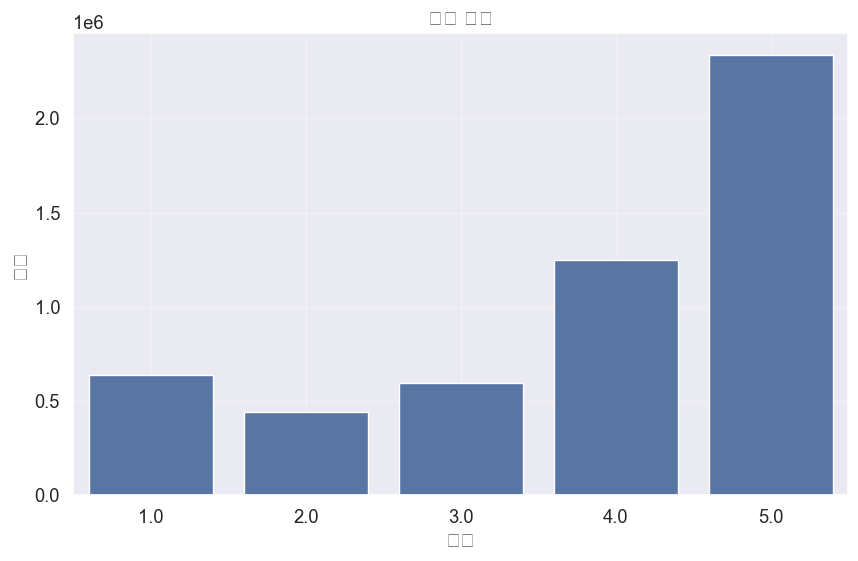

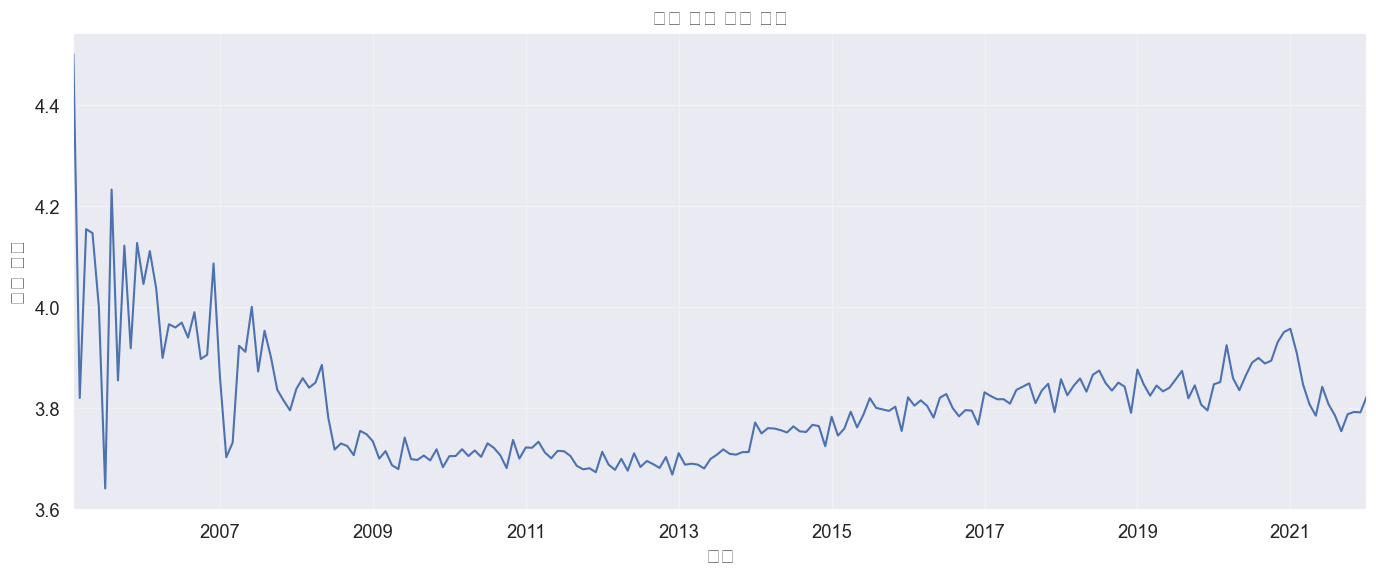

In [14]:
## 8. 평점 분포 확인 및 시각화

# 평점 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=interaction_df)
plt.title('평점 분포')
plt.xlabel('평점')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)
plt.show()

# 시간에 따른 평점 추이
interaction_df['date'] = pd.to_datetime(interaction_df['timestamp'], unit='s')
interaction_df['year_month'] = interaction_df['date'].dt.to_period('M')

monthly_ratings = interaction_df.groupby('year_month')['rating'].mean()

plt.figure(figsize=(14, 6))
monthly_ratings.plot()
plt.title('월별 평균 평점 추이')
plt.xlabel('년월')
plt.ylabel('평균 평점')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



--- 샘플 1 ---
원본: I took my girlfriend here for our anniversary. Our waiter was well mannered and nicely dressed. He paid attention to every table he was in charge of. My dry aged NY strip was perfectly cooked. The fil...
전처리 후: i took my girlfriend here for our anniversary our waiter was well mannered and nicely dressed he paid attention to every table he was in charge of my dry aged ny strip was perfectly cooked the filet a...

--- 샘플 2 ---
원본: Very nice place to sit outside for a summer meal.  Service was excellent and very attentive.  Food was a bit pricey for quality though....
전처리 후: very nice place to sit outside for a summer meal service was excellent and very attentive food was a bit pricey for quality though...

--- 샘플 3 ---
원본: We took the quick route and did the walk in side as a late dinner! The line and service were fast! Local beers on tap and very friendly service. Pizza slices are huge and very delicious! Pre selected ...
전처리 후: we took the quick route and did the walk

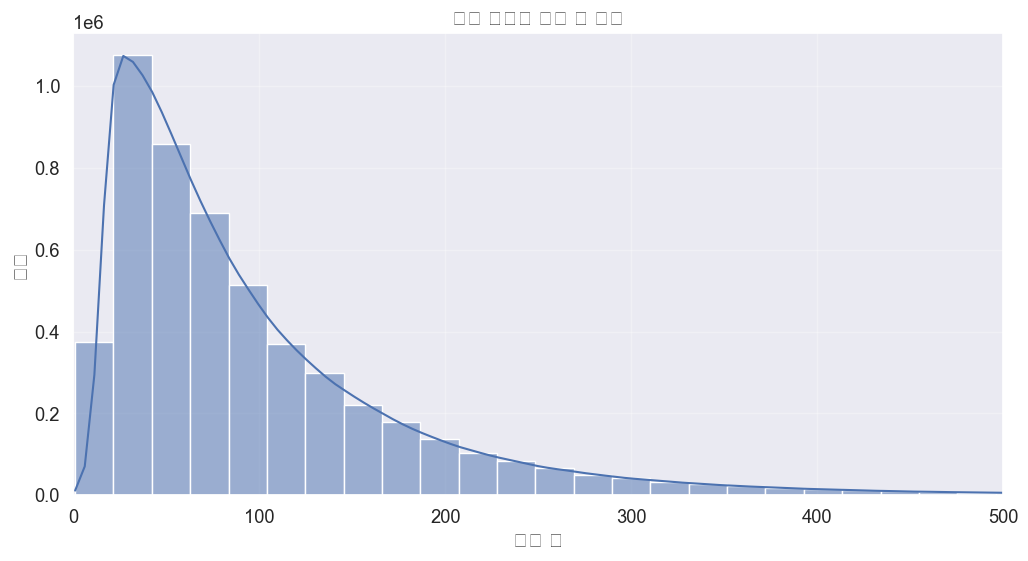

리뷰 텍스트 평균 단어 수: 100.09
리뷰 텍스트 중앙값 단어 수: 71.0
리뷰 텍스트 최대 단어 수: 1032


In [15]:
## 9. 리뷰 텍스트 기본 전처리

def clean_text(text):
    """
    리뷰 텍스트 기본 전처리
    - 소문자 변환
    - HTML 태그 제거
    - 특수문자 제거
    """
    if not isinstance(text, str):
        return ""
    
    # 소문자 변환
    text = text.lower()
    
    # HTML 태그 제거
    text = re.sub(r'<.*?>', '', text)
    
    # 특수문자 제거 (알파벳, 숫자, 공백만 유지)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # 여러 공백을 하나로 치환
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 리뷰 텍스트 전처리
interaction_df['clean_text'] = interaction_df['text'].apply(clean_text)

# 전처리 전/후 텍스트 샘플 확인
text_samples = interaction_df[['text', 'clean_text']].sample(5)
for i, (original, cleaned) in enumerate(zip(text_samples['text'], text_samples['clean_text'])):
    print(f"\n--- 샘플 {i+1} ---")
    print(f"원본: {original[:200]}...")
    print(f"전처리 후: {cleaned[:200]}...")

# 텍스트 길이 분석
interaction_df['text_length'] = interaction_df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
interaction_df['clean_text_length'] = interaction_df['clean_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(12, 6))
sns.histplot(interaction_df['text_length'], bins=50, kde=True)
plt.title('리뷰 텍스트 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.xlim(0, 500)  # 가독성을 위해 x축 제한
plt.grid(True, alpha=0.3)
plt.show()

print(f"리뷰 텍스트 평균 단어 수: {interaction_df['text_length'].mean():.2f}")
print(f"리뷰 텍스트 중앙값 단어 수: {interaction_df['text_length'].median()}")
print(f"리뷰 텍스트 최대 단어 수: {interaction_df['text_length'].max()}")

처리된 팁 데이터 크기: (207735, 6)
   user_idx  item_idx  compliment_count   timestamp  \
3     31994     15609                 0  1498604738   
4     15502     31235                 0  1349552589   
5      1382     28713                 0  1331611252   
7     17488     26396                 0  1479852898   
8      3511      5026                 0  1343353704   

                                                text  \
3                          Very decent fried chicken   
4             Appetizers.. platter special for lunch   
5  Chili Cup + Single Cheeseburger with onion, pi...   
7  This is probably the best place in the cool Sp...   
8                                              Tacos   

                                          clean_text  
3                          very decent fried chicken  
4               appetizers platter special for lunch  
5  chili cup single cheeseburger with onion pickl...  
7  this is probably the best place in the cool sp...  
8                              

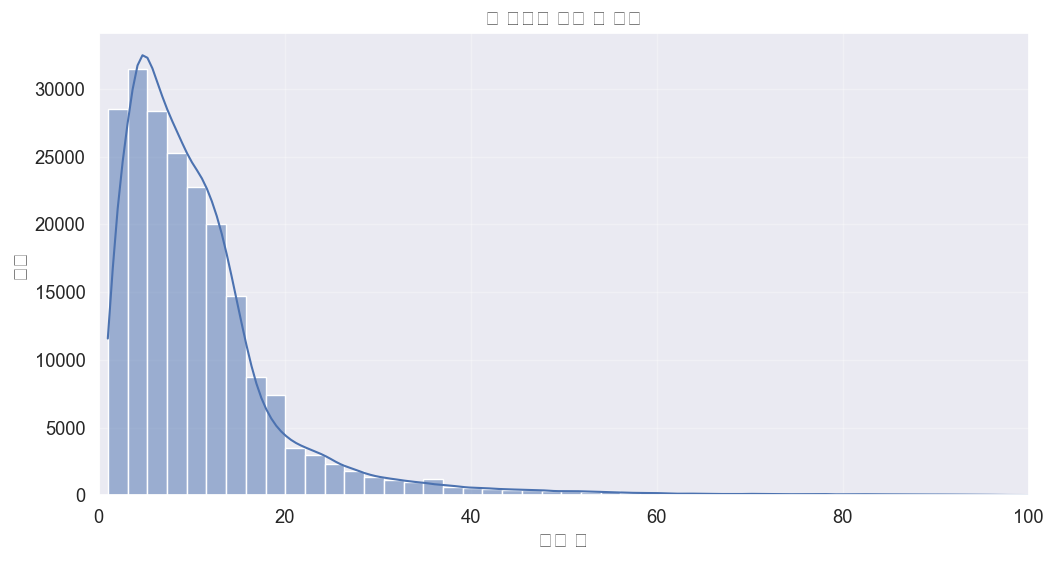

팁 텍스트 평균 단어 수: 10.96
팁 텍스트 중앙값 단어 수: 9.0
팁 텍스트 최대 단어 수: 107


In [16]:
## 10. 팁 데이터 전처리 

def process_tip_data(tip_df, user_to_idx, business_to_idx):
    """
    팁 데이터 전처리
    
    Returns:
        pd.DataFrame: 전처리된 팁 데이터
    """
    # 매핑된 ID만 필터링
    valid_tips = tip_df[
        (tip_df['user_id'].isin(user_to_idx.keys())) & 
        (tip_df['business_id'].isin(business_to_idx.keys()))
    ]
    
    # 팁 데이터프레임 생성
    tip_processed = pd.DataFrame({
        'user_idx': valid_tips['user_id'].map(user_to_idx),
        'item_idx': valid_tips['business_id'].map(business_to_idx),
        'compliment_count': valid_tips['compliment_count'],
        # 날짜 변환 수정 - int64를 거쳐서 변환
        'timestamp': pd.to_datetime(valid_tips['date']).astype('int64') // 10**9,  # Unix timestamp
        'text': valid_tips['text'],
        'clean_text': valid_tips['text'].apply(clean_text) if 'clean_text' in globals() else valid_tips['text']
    })
    
    return tip_processed

# 팁 데이터 전처리
tip_processed = process_tip_data(sampled_tip, user_to_idx, business_to_idx)
print(f"처리된 팁 데이터 크기: {tip_processed.shape}")
print(tip_processed.head())

# 팁 텍스트 길이 분석
tip_processed['text_length'] = tip_processed['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(12, 6))
sns.histplot(tip_processed['text_length'], bins=50, kde=True)
plt.title('팁 텍스트 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.xlim(0, 100)  # 가독성을 위해 x축 제한
plt.grid(True, alpha=0.3)
plt.show()

print(f"팁 텍스트 평균 단어 수: {tip_processed['text_length'].mean():.2f}")
print(f"팁 텍스트 중앙값 단어 수: {tip_processed['text_length'].median()}")
print(f"팁 텍스트 최대 단어 수: {tip_processed['text_length'].max()}")

처리된 사용자 데이터 크기: (455477, 20)
    user_idx  review_count       yelping_since  fans  average_stars  \
0          0           585 2007-01-25 16:47:26   267           3.91   
1          1          4333 2009-01-25 04:35:42  3138           3.74   
4          2            79 2007-01-05 19:40:59     1           3.54   
7          3           358 2008-12-11 22:11:56    23           3.73   
29         4           801 2008-08-16 22:43:21    75           3.41   

    compliment_hot  compliment_more  compliment_profile  compliment_cute  \
0              250               65                  55               56   
1             1145              264                 184              157   
4                1                1                   0                0   
7                4                7                   2                0   
29              24                5                   1               10   

    compliment_list  compliment_note  compliment_plain  compliment_cool  \
0           

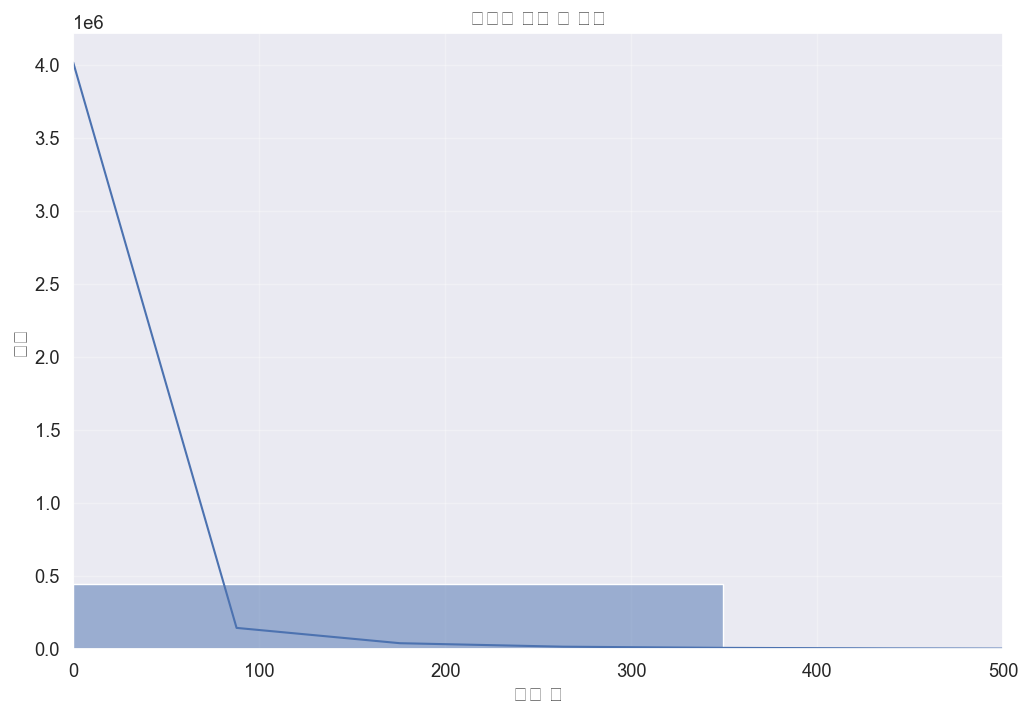

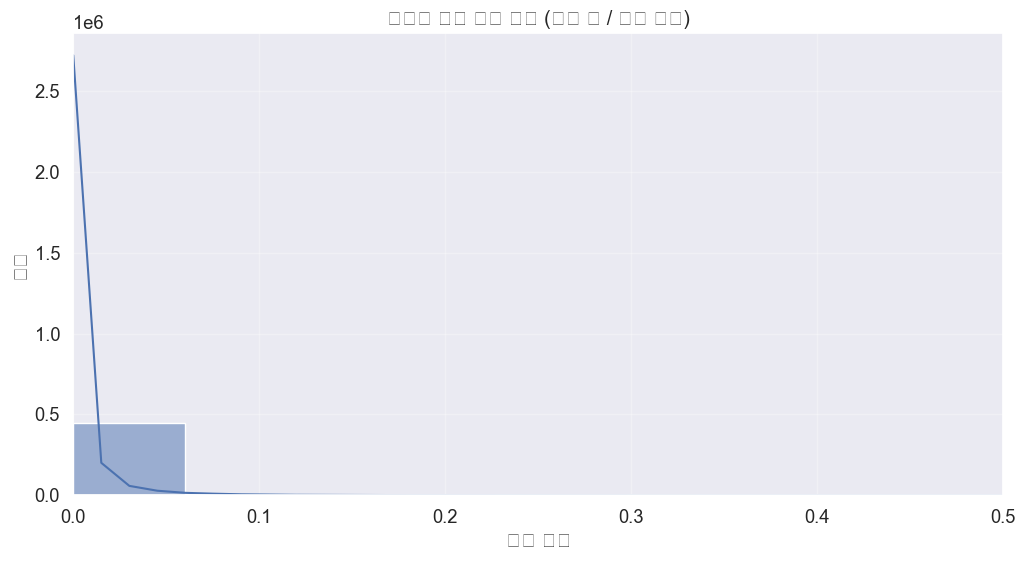

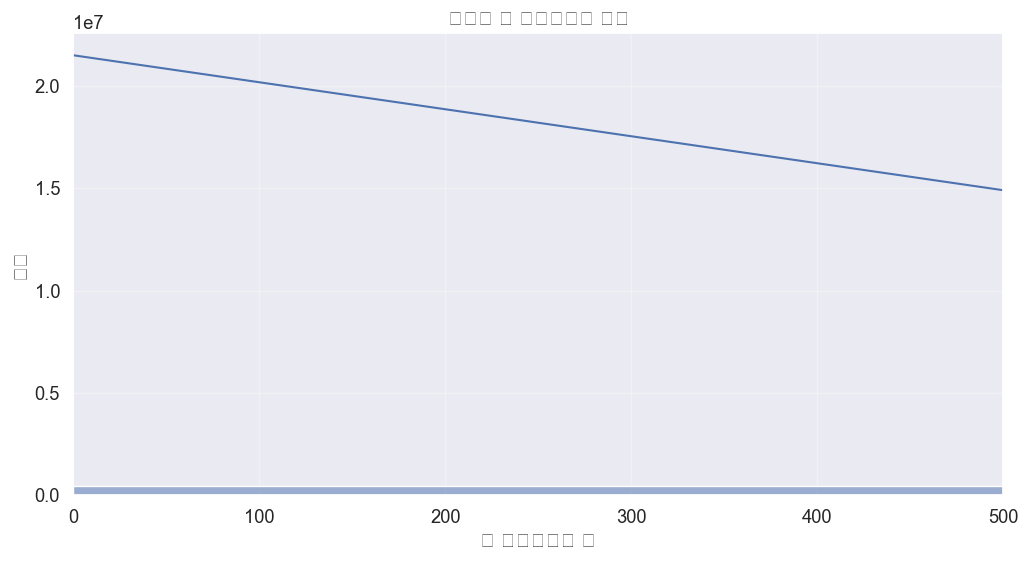

In [17]:
## 11. 사용자 정보 전처리

def process_user_data(user_df, user_to_idx):
    """
    사용자 데이터 전처리
    
    Returns:
        pd.DataFrame: 전처리된 사용자 데이터
    """
    # 매핑된 ID만 필터링
    valid_users = user_df[user_df['user_id'].isin(user_to_idx.keys())]
    
    # 사용자 데이터프레임 생성
    user_processed = pd.DataFrame({
        'user_idx': valid_users['user_id'].map(user_to_idx),
        'review_count': valid_users['review_count'],
        'yelping_since': pd.to_datetime(valid_users['yelping_since']),
        'fans': valid_users['fans'],
        'average_stars': valid_users['average_stars'],
        'compliment_hot': valid_users['compliment_hot'],
        'compliment_more': valid_users['compliment_more'],
        'compliment_profile': valid_users['compliment_profile'],
        'compliment_cute': valid_users['compliment_cute'],
        'compliment_list': valid_users['compliment_list'],
        'compliment_note': valid_users['compliment_note'],
        'compliment_plain': valid_users['compliment_plain'],
        'compliment_cool': valid_users['compliment_cool'],
        'compliment_funny': valid_users['compliment_funny'],
        'compliment_writer': valid_users['compliment_writer'],
        'compliment_photos': valid_users['compliment_photos']
    })
    
    # 활동 기간 계산 (일 단위)
    user_processed['days_active'] = (pd.Timestamp.now() - user_processed['yelping_since']).dt.days
    
    # 활동 강도 (리뷰 수 / 활동 기간)
    user_processed['activity_intensity'] = user_processed['review_count'] / user_processed['days_active']
    
    # 엘리트 상태 지표 (엘리트 기간 연수)
    if 'elite' in valid_users.columns:
        user_processed['elite_years'] = valid_users['elite'].apply(
            lambda x: len(x.split(',')) if isinstance(x, str) and x.strip() else 0
        )
    
    # 컴플리먼트 총합
    compliment_cols = [col for col in user_processed.columns if 'compliment_' in col]
    user_processed['total_compliments'] = user_processed[compliment_cols].sum(axis=1)
    
    return user_processed

# 사용자 데이터 전처리
user_processed = process_user_data(sampled_user, user_to_idx)
print(f"처리된 사용자 데이터 크기: {user_processed.shape}")
print(user_processed.head())

# 사용자 특성 시각화
plt.figure(figsize=(12, 8))
sns.histplot(user_processed['review_count'], bins=50, kde=True)
plt.title('사용자 리뷰 수 분포')
plt.xlabel('리뷰 수')
plt.ylabel('빈도')
plt.xlim(0, 500)  # 가독성을 위해 x축 제한
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(user_processed['activity_intensity'], bins=50, kde=True)
plt.title('사용자 활동 강도 분포 (리뷰 수 / 활동 기간)')
plt.xlabel('활동 강도')
plt.ylabel('빈도')
plt.xlim(0, 0.5)  # 가독성을 위해 x축 제한
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(user_processed['total_compliments'], bins=50, kde=True)
plt.title('사용자 총 컴플리먼트 분포')
plt.xlabel('총 컴플리먼트 수')
plt.ylabel('빈도')
plt.xlim(0, 500)  # 가독성을 위해 x축 제한
plt.grid(True, alpha=0.3)
plt.show()

처리된 비즈니스 데이터 크기: (39481, 38)
    item_idx                name          city state  stars  review_count  \
3          0  St Honore Pastries  Philadelphia    PA    4.0            80   
9          1      Sonic Drive-In     Nashville    TN    1.5            10   
12         2             Denny's  Indianapolis    IN    2.5            28   
15         3            Tuna Bar  Philadelphia    PA    4.0           245   
19         4                 BAP  Philadelphia    PA    4.5           205   

    is_open                                         categories  \
3         1  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
9         1  Ice Cream & Frozen Yogurt, Fast Food, Burgers,...   
12        1  American (Traditional), Restaurants, Diners, B...   
15        1                  Sushi Bars, Restaurants, Japanese   
19        1                                Korean, Restaurants   

    cat_restaurants  cat_food  ...  cat_chinese  cat_grocery  \
3                 1         1  ...            0

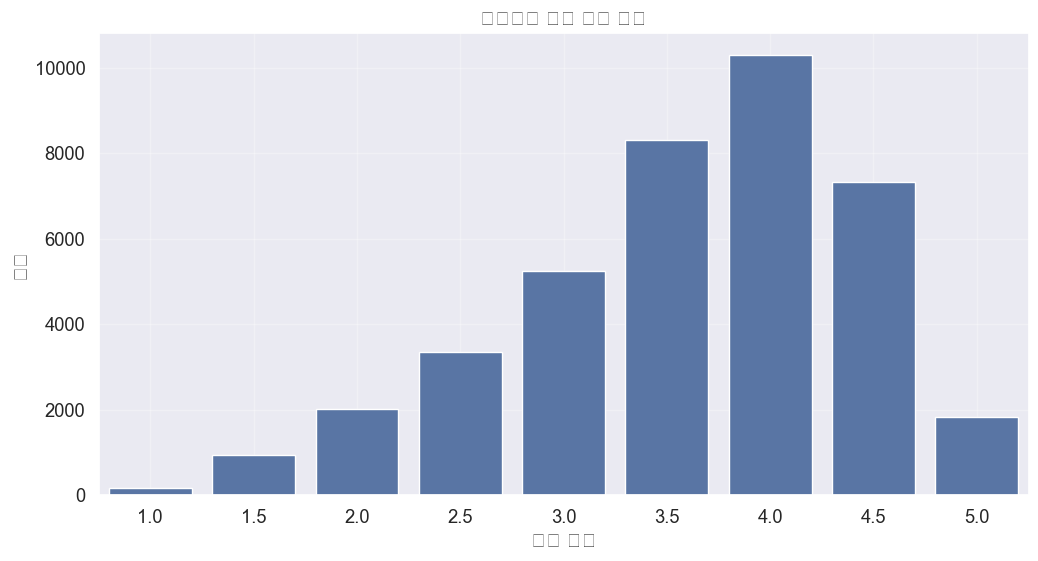

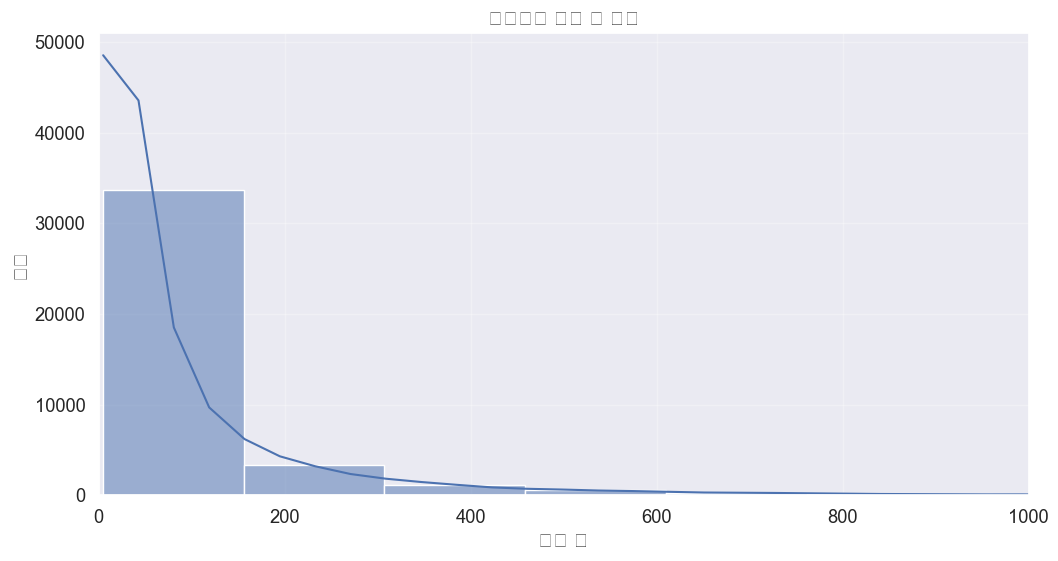

In [18]:
## 12. 비즈니스 정보 전처리

def process_business_data(business_df, business_to_idx):
    """
    비즈니스 데이터 전처리
    
    Returns:
        pd.DataFrame: 전처리된 비즈니스 데이터
    """
    # 매핑된 ID만 필터링
    valid_business = business_df[business_df['business_id'].isin(business_to_idx.keys())]
    
    # 비즈니스 데이터프레임 생성
    business_processed = pd.DataFrame({
        'item_idx': valid_business['business_id'].map(business_to_idx),
        'name': valid_business['name'],
        'city': valid_business['city'],
        'state': valid_business['state'],
        'stars': valid_business['stars'],
        'review_count': valid_business['review_count'],
        'is_open': valid_business['is_open'],
        'categories': valid_business['categories']
    })
    
    # 카테고리 원-핫 인코딩
    # 상위 30개 카테고리만 추출
    all_categories = []
    for cats in valid_business['categories'].dropna():
        if isinstance(cats, str):
            all_categories.extend([c.strip() for c in cats.split(',')])
    
    category_counts = pd.Series(all_categories).value_counts()
    top_categories = category_counts.head(30).index.tolist()
    
    for category in top_categories:
        business_processed[f'cat_{category.replace(" ", "_").lower()}'] = \
            business_processed['categories'].apply(
                lambda x: 1 if isinstance(x, str) and category in x else 0
            )
    
    return business_processed

# 비즈니스 데이터 전처리
business_processed = process_business_data(sampled_business, business_to_idx)
print(f"처리된 비즈니스 데이터 크기: {business_processed.shape}")
print(business_processed.head())

# 비즈니스 특성 시각화
plt.figure(figsize=(12, 6))
sns.countplot(x='stars', data=business_processed)
plt.title('비즈니스 평균 별점 분포')
plt.xlabel('평균 별점')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(business_processed['review_count'], bins=50, kde=True)
plt.title('비즈니스 리뷰 수 분포')
plt.xlabel('리뷰 수')
plt.ylabel('빈도')
plt.xlim(0, 1000)  # 가독성을 위해 x축 제한
plt.grid(True, alpha=0.3)
plt.show()

##13은 쓸지 고민민

In [20]:
## 13. 훈련/검증/테스트 데이터 분할

def train_val_test_split(interactions, val_ratio=0.1, test_ratio=0.1, by_user=True):
    """
    상호작용 데이터를 훈련/검증/테스트 세트로 분할
    
    Args:
        interactions (pd.DataFrame): 상호작용 데이터프레임
        val_ratio (float): 검증 세트 비율
        test_ratio (float): 테스트 세트 비율
        by_user (bool): 사용자별로 분할 여부
    
    Returns:
        tuple: (train_df, val_df, test_df) 분할된 데이터프레임
    """
    train_df, val_df, test_df = [], [], []
    
    if by_user:
        # 사용자별로 분할
        for user_idx, user_data in interactions.groupby('user_idx'):
            # 시간순 정렬
            user_data = user_data.sort_values('timestamp')
            
            n_interactions = len(user_data)
            n_test = max(1, int(n_interactions * test_ratio))
            n_val = max(1, int(n_interactions * val_ratio))
            
            # 적어도 1개의 상호작용이 훈련 세트에 있도록 보장
            if n_interactions <= 3:
                train_df.append(user_data.iloc[:1])
                if n_interactions > 1:
                    val_df.append(user_data.iloc[1:2])
                if n_interactions > 2:
                    test_df.append(user_data.iloc[2:])
            else:
                test_df.append(user_data.iloc[-n_test:])
                val_df.append(user_data.iloc[-(n_test+n_val):-n_test])
                train_df.append(user_data.iloc[:-(n_test+n_val)])
    else:
        # 전체 데이터 기준으로 분할
        interactions = interactions.sort_values('timestamp')
        n_interactions = len(interactions)
        n_test = int(n_interactions * test_ratio)
        n_val = int(n_interactions * val_ratio)
        
        test_df = [interactions.iloc[-n_test:]]
        val_df = [interactions.iloc[-(n_test+n_val):-n_test]]
        train_df = [interactions.iloc[:-(n_test+n_val)]]
    
    # 데이터프레임 결합
    train_df = pd.concat(train_df).reset_index(drop=True)
    val_df = pd.concat(val_df).reset_index(drop=True)
    test_df = pd.concat(test_df).reset_index(drop=True)
    
    return train_df, val_df, test_df

# 데이터 분할
train_df, val_df, test_df = train_val_test_split(interaction_df, val_ratio=0.1, test_ratio=0.1, by_user=True)

print(f"훈련 세트 크기: {len(train_df):,} ({len(train_df)/len(interaction_df):.1%})")
print(f"검증 세트 크기: {len(val_df):,} ({len(val_df)/len(interaction_df):.1%})")
print(f"테스트 세트 크기: {len(test_df):,} ({len(test_df)/len(interaction_df):.1%})")

# 분할된 세트에서 사용자와 아이템 수 확인
print(f"훈련 세트 사용자 수: {train_df['user_idx'].nunique():,}")
print(f"검증 세트 사용자 수: {val_df['user_idx'].nunique():,}")
print(f"테스트 세트 사용자 수: {test_df['user_idx'].nunique():,}")

print(f"훈련 세트 아이템 수: {train_df['item_idx'].nunique():,}")
print(f"검증 세트 아이템 수: {val_df['item_idx'].nunique():,}")
print(f"테스트 세트 아이템 수: {test_df['item_idx'].nunique():,}")

훈련 세트 크기: 20,674 (77.9%)
검증 세트 크기: 4,128 (15.5%)
테스트 세트 크기: 1,748 (6.6%)
훈련 세트 사용자 수: 18,129
검증 세트 사용자 수: 4,118
테스트 세트 사용자 수: 1,738
훈련 세트 아이템 수: 3,486
검증 세트 아이템 수: 1,806
테스트 세트 아이템 수: 1,106


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# 데이터를 청크로 나누어 파일로 저장하는 함수
def split_data_to_chunks(df, chunk_size=100000, output_dir='./data/chunks'):
    """데이터프레임을 작은 청크로 나누어 파일로 저장"""
    os.makedirs(output_dir, exist_ok=True)
    
    # 청크 수 계산
    n_chunks = (len(df) + chunk_size - 1) // chunk_size
    
    # 청크별로 저장
    chunk_files = []
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        
        chunk = df.iloc[start_idx:end_idx]
        chunk_file = os.path.join(output_dir, f'chunk_{i:03d}.pkl')
        chunk.to_pickle(chunk_file)
        chunk_files.append(chunk_file)
        
    return chunk_files

# 사용자별 상호작용 수 계산 함수 (파일 기반)
def count_user_interactions(chunk_files):
    """청크 파일들을 순회하며 사용자별 상호작용 수 계산"""
    user_counts = {}
    
    for chunk_file in tqdm(chunk_files, desc="사용자별 상호작용 수 계산"):
        chunk = pd.read_pickle(chunk_file)
        
        # 사용자별 카운트 집계
        for user_idx, count in chunk['user_idx'].value_counts().items():
            if user_idx in user_counts:
                user_counts[user_idx] += count
            else:
                user_counts[user_idx] = count
    
    return user_counts

# 파일 기반 훈련/검증/테스트 분할 함수
def file_based_train_val_test_split(chunk_files, user_counts, val_ratio=0.1, test_ratio=0.1, 
                                    min_train_per_user=3, random_seed=42,
                                    output_dir='./data/processed'):
    """파일 기반 훈련/검증/테스트 세트 분할 함수"""
    np.random.seed(random_seed)
    os.makedirs(output_dir, exist_ok=True)
    
    # 충분한 상호작용이 있는 사용자와 그렇지 않은 사용자 분리
    sufficient_users = set()
    insufficient_users = set()
    
    for user_idx, count in user_counts.items():
        if count >= (min_train_per_user + 2):
            sufficient_users.add(user_idx)
        else:
            insufficient_users.add(user_idx)
    
    print(f"충분한 상호작용이 있는 사용자: {len(sufficient_users):,}")
    print(f"상호작용이 부족한 사용자: {len(insufficient_users):,}")
    
    # 사용자별 데이터 준비
    user_data = {}
    
    # 청크 파일 순회하며 사용자별 데이터 수집
    for chunk_file in tqdm(chunk_files, desc="사용자별 데이터 수집"):
        chunk = pd.read_pickle(chunk_file)
        
        for user_idx in set(chunk['user_idx'].unique()):
            user_chunk = chunk[chunk['user_idx'] == user_idx]
            
            if user_idx not in user_data:
                user_data[user_idx] = user_chunk
            else:
                user_data[user_idx] = pd.concat([user_data[user_idx], user_chunk])
    
    # 결과 파일 준비
    train_file = os.path.join(output_dir, 'train_df.pkl')
    val_file = os.path.join(output_dir, 'val_df.pkl')
    test_file = os.path.join(output_dir, 'test_df.pkl')
    
    train_chunks = []
    val_chunks = []
    test_chunks = []
    
    # 사용자별 처리
    for user_idx, user_df in tqdm(user_data.items(), desc="데이터 분할"):
        # 타임스탬프 기준 정렬 또는 랜덤 셔플
        if 'timestamp' in user_df.columns:
            user_df = user_df.sort_values('timestamp')
        else:
            user_df = user_df.sample(frac=1, random_state=random_seed + hash(str(user_idx)) % 10000)
        
        if user_idx in sufficient_users:
            n_interactions = len(user_df)
            n_test = max(1, int(n_interactions * test_ratio))
            n_val = max(1, int(n_interactions * val_ratio))
            n_train = n_interactions - n_test - n_val
            
            # 최소 훈련 데이터 수 보장
            if n_train < min_train_per_user:
                n_train = min_train_per_user
                n_left = n_interactions - n_train
                n_val = int(n_left * (val_ratio / (val_ratio + test_ratio)))
                n_test = n_left - n_val
            
            # 데이터 분할
            train_chunks.append(user_df.iloc[:n_train])
            val_chunks.append(user_df.iloc[n_train:n_train+n_val])
            test_chunks.append(user_df.iloc[n_train+n_val:])
        else:
            # 상호작용이 부족한 사용자는 모두 훈련 데이터로
            train_chunks.append(user_df)
        
        # 메모리 관리를 위해 중간 결과 저장 및 메모리 해제
        if len(train_chunks) % 1000 == 0:
            # 기존 파일에 추가
            if os.path.exists(train_file):
                existing_train = pd.read_pickle(train_file)
                train_df = pd.concat([existing_train] + train_chunks)
                train_df.to_pickle(train_file)
            else:
                train_df = pd.concat(train_chunks)
                train_df.to_pickle(train_file)
            
            if val_chunks:
                if os.path.exists(val_file):
                    existing_val = pd.read_pickle(val_file)
                    val_df = pd.concat([existing_val] + val_chunks)
                    val_df.to_pickle(val_file)
                else:
                    val_df = pd.concat(val_chunks)
                    val_df.to_pickle(val_file)
            
            if test_chunks:
                if os.path.exists(test_file):
                    existing_test = pd.read_pickle(test_file)
                    test_df = pd.concat([existing_test] + test_chunks)
                    test_df.to_pickle(test_file)
                else:
                    test_df = pd.concat(test_chunks)
                    test_df.to_pickle(test_file)
            
            # 메모리 해제
            train_chunks = []
            val_chunks = []
            test_chunks = []
    
    # 남은 데이터 저장
    if train_chunks:
        if os.path.exists(train_file):
            existing_train = pd.read_pickle(train_file)
            train_df = pd.concat([existing_train] + train_chunks)
            train_df.to_pickle(train_file)
        else:
            train_df = pd.concat(train_chunks)
            train_df.to_pickle(train_file)
    
    if val_chunks:
        if os.path.exists(val_file):
            existing_val = pd.read_pickle(val_file)
            val_df = pd.concat([existing_val] + val_chunks)
            val_df.to_pickle(val_file)
        else:
            val_df = pd.concat(val_chunks)
            val_df.to_pickle(val_file)
    
    if test_chunks:
        if os.path.exists(test_file):
            existing_test = pd.read_pickle(test_file)
            test_df = pd.concat([existing_test] + test_chunks)
            test_df.to_pickle(test_file)
        else:
            test_df = pd.concat(test_chunks)
            test_df.to_pickle(test_file)
    
    # 결과 로드 및 통계 출력
    train_df = pd.read_pickle(train_file)
    val_df = pd.read_pickle(val_file)
    test_df = pd.read_pickle(test_file)
    
    print(f"\n훈련 세트 크기: {len(train_df):,}")
    print(f"검증 세트 크기: {len(val_df):,}")
    print(f"테스트 세트 크기: {len(test_df):,}")
    
    return train_file, val_file, test_file

# 메인 실행 코드
def process_full_dataset(interaction_df, chunk_size=100000):
    """전체 데이터셋 처리 메인 함수"""
    # 1. 데이터를 청크로 나누어 저장
    print("데이터를 청크로 나누는 중...")
    chunk_files = split_data_to_chunks(interaction_df, chunk_size=chunk_size)
    print(f"생성된 청크 파일 수: {len(chunk_files)}")
    
    # 2. 사용자별 상호작용 수 계산
    print("사용자별 상호작용 수 계산 중...")
    user_counts = count_user_interactions(chunk_files)
    print(f"총 사용자 수: {len(user_counts):,}")
    
    # 3. 훈련/검증/테스트 세트 분할
    print("데이터 분할 중...")
    train_file, val_file, test_file = file_based_train_val_test_split(
        chunk_files, 
        user_counts, 
        val_ratio=0.1, 
        test_ratio=0.1, 
        min_train_per_user=5
    )
    
    print("\n데이터 분할 완료!")
    print(f"훈련 세트 파일: {train_file}")
    print(f"검증 세트 파일: {val_file}")
    print(f"테스트 세트 파일: {test_file}")
    
    return train_file, val_file, test_file

# 실행
process_full_dataset(interaction_df, chunk_size=100000)

데이터를 청크로 나누는 중...
생성된 청크 파일 수: 53
사용자별 상호작용 수 계산 중...


사용자별 상호작용 수 계산: 100%|██████████| 53/53 [00:28<00:00,  1.87it/s]


총 사용자 수: 1,529,126
데이터 분할 중...
충분한 상호작용이 있는 사용자: 140,008
상호작용이 부족한 사용자: 1,389,118


Exception ignored in: <function tqdm.__del__ at 0x000001D5FD9D1240>
Traceback (most recent call last):
  File "c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


100%|██████████| 430/430 [00:00<00:00, 3084.11it/s]


부정적 샘플 생성 후 훈련 데이터 크기: (22906, 4)
긍정적 샘플 수: 20,674
부정적 샘플 수: 2,232


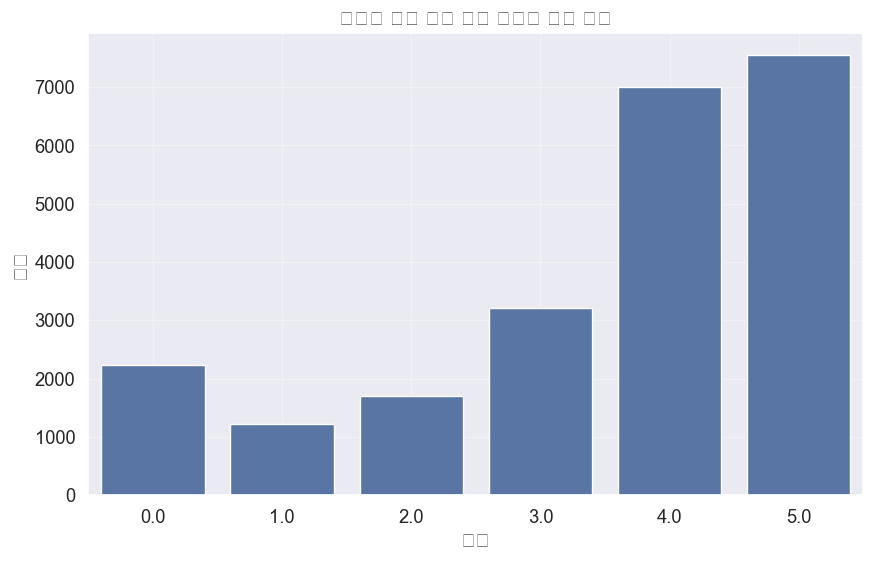

In [21]:
## 14. 부정적 샘플 생성 (학습용)

def generate_negative_samples(interaction_df, user_df, item_df, neg_ratio=4):
    """
    부정적 샘플 생성 (사용자가 상호작용하지 않은 아이템)
    
    Args:
        interaction_df (pd.DataFrame): 상호작용 데이터프레임
        user_df (pd.DataFrame): 사용자 데이터프레임
        item_df (pd.DataFrame): 아이템 데이터프레임
        neg_ratio (int): 부정적 샘플 비율 (positive:negative = 1:neg_ratio)
    
    Returns:
        pd.DataFrame: 부정적 샘플이 추가된 데이터프레임
    """
    # 모든 사용자-아이템 상호작용 쌍을 세트로 저장
    user_item_set = set(zip(interaction_df['user_idx'], interaction_df['item_idx']))
    
    # 부정적 샘플 리스트
    neg_samples = []
    
    # 모든 아이템 ID 리스트
    all_items = item_df['item_idx'].unique()
    
    # 각 사용자에 대해 부정적 샘플 생성
    for user_idx in tqdm(user_df['user_idx'].unique()):
        # 사용자가 상호작용한 아이템 수
        n_pos_items = interaction_df[interaction_df['user_idx'] == user_idx].shape[0]
        
        # 생성할 부정적 샘플 수
        n_neg_samples = min(n_pos_items * neg_ratio, len(all_items) - n_pos_items)
        
        # 부정적 샘플 생성 카운터
        count = 0
        tried_items = set()
        
        # 최대 100번 시도까지만 (무한 루프 방지)
        for _ in range(min(n_neg_samples * 100, 1000)):
            if count >= n_neg_samples:
                break
                
            # 랜덤 아이템 선택
            neg_item = np.random.choice(all_items)
            
            # 이미 시도한 아이템이면 스킵
            if neg_item in tried_items:
                continue
                
            tried_items.add(neg_item)
            
            # 상호작용이 없는 아이템이면 부정적 샘플로 추가
            if (user_idx, neg_item) not in user_item_set:
                neg_samples.append({
                    'user_idx': user_idx,
                    'item_idx': neg_item,
                    'rating': 0,  # 부정적 샘플은 평점 0으로 표시
                    'is_negative': 1  # 부정적 샘플 표시
                })
                count += 1
    
    # 부정적 샘플 데이터프레임 생성
    neg_df = pd.DataFrame(neg_samples)
    
    # 긍정적 샘플에 표시 추가
    interaction_df['is_negative'] = 0
    
    # 필요한 컬럼만 선택하여 두 데이터프레임 결합
    cols_to_keep = ['user_idx', 'item_idx', 'rating', 'is_negative']
    pos_df = interaction_df[cols_to_keep].copy()
    
    # 결합된 데이터프레임 반환
    combined_df = pd.concat([pos_df, neg_df]).reset_index(drop=True)
    
    return combined_df

# 훈련 세트에 대해 부정적 샘플 생성
train_with_neg = generate_negative_samples(
    train_df, 
    user_processed[user_processed['user_idx'].isin(train_df['user_idx'])],
    business_processed[business_processed['item_idx'].isin(train_df['item_idx'])],
    neg_ratio=4
)

print(f"부정적 샘플 생성 후 훈련 데이터 크기: {train_with_neg.shape}")
print(f"긍정적 샘플 수: {train_with_neg[train_with_neg['is_negative'] == 0].shape[0]:,}")
print(f"부정적 샘플 수: {train_with_neg[train_with_neg['is_negative'] == 1].shape[0]:,}")

# 평점 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=train_with_neg)
plt.title('부정적 샘플 포함 훈련 데이터 평점 분포')
plt.xlabel('평점')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
## 15. 처리된 데이터 저장

# 필요한 데이터 저장
data_to_save = {
    'interaction_df': interaction_df,
    'train_df': train_df,
    'val_df': val_df,
    'test_df': test_df,
    'train_with_neg': train_with_neg,
    'user_processed': user_processed,
    'business_processed': business_processed,
    'tip_processed': tip_processed,
    'user_to_idx': user_to_idx,
    'idx_to_user': idx_to_user,
    'business_to_idx': business_to_idx,
    'idx_to_business': idx_to_business
}

# 데이터 저장
for name, data in data_to_save.items():
    file_path = os.path.join(PROCESSED_DIR, f"{name}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"{name} 저장 완료: {file_path}")

## 16. 데이터 분석 요약

print("\n===== 데이터 분석 요약 =====")
print(f"총 사용자 수: {len(user_processed):,}")
print(f"총 비즈니스 수: {len(business_processed):,}")
print(f"총 상호작용 수: {len(interaction_df):,}")
print(f"총 팁 수: {len(tip_processed):,}")

print("\n평균 평점: {:.2f}".format(interaction_df['rating'].mean()))
print("평점 분포:")
for rating, count in sorted(interaction_df['rating'].value_counts().items()):
    print(f"  {rating}: {count:,} ({count/len(interaction_df):.1%})")

print("\n사용자당 평균 리뷰 수: {:.2f}".format(interaction_df.groupby('user_idx').size().mean()))
print("비즈니스당 평균 리뷰 수: {:.2f}".format(interaction_df.groupby('item_idx').size().mean()))

print("\n리뷰 텍스트 평균 단어 수: {:.2f}".format(interaction_df['text_length'].mean()))
print("팁 텍스트 평균 단어 수: {:.2f}".format(tip_processed['text_length'].mean()))

print("\n상위 5개 도시:")
city_counts = business_processed['city'].value_counts().head(5)
for city, count in city_counts.items():
    print(f"  {city}: {count:,} ({count/len(business_processed):.1%})")

print("\n상위 10개 카테고리:")
# 모든 카테고리 추출
all_categories = []
for cats in business_processed['categories'].dropna():
    if isinstance(cats, str):
        all_categories.extend([c.strip() for c in cats.split(',')])

category_counts = pd.Series(all_categories).value_counts().head(10)
for category, count in category_counts.items():
    print(f"  {category}: {count:,}")

print("\n데이터 전처리 완료!")

interaction_df 저장 완료: ./data/processed\interaction_df.pkl
train_df 저장 완료: ./data/processed\train_df.pkl
val_df 저장 완료: ./data/processed\val_df.pkl
test_df 저장 완료: ./data/processed\test_df.pkl
train_with_neg 저장 완료: ./data/processed\train_with_neg.pkl
user_processed 저장 완료: ./data/processed\user_processed.pkl
business_processed 저장 완료: ./data/processed\business_processed.pkl
tip_processed 저장 완료: ./data/processed\tip_processed.pkl
user_to_idx 저장 완료: ./data/processed\user_to_idx.pkl
idx_to_user 저장 완료: ./data/processed\idx_to_user.pkl
business_to_idx 저장 완료: ./data/processed\business_to_idx.pkl
idx_to_business 저장 완료: ./data/processed\idx_to_business.pkl

===== 데이터 분석 요약 =====
총 사용자 수: 430
총 비즈니스 수: 7,044
총 상호작용 수: 26,550
총 팁 수: 515

평균 평점: 3.86
평점 분포:
  1.0: 1,441 (5.4%)
  2.0: 2,181 (8.2%)
  3.0: 4,309 (16.2%)
  4.0: 9,239 (34.8%)
  5.0: 9,380 (35.3%)

사용자당 평균 리뷰 수: 1.46
비즈니스당 평균 리뷰 수: 6.93

리뷰 텍스트 평균 단어 수: 121.69
팁 텍스트 평균 단어 수: 11.70

상위 5개 도시:
  Philadelphia: 2,447 (34.7%)
  Tampa: 1,267 (18.